# Abstract Interpretation

In the previous chapter we considered basic dataflow analysis; in this chapter we are going to generalize the iterative framework introduced to a lattice based one, which allows us to perform abstract interpretation of programs. The latteice-based framework also provides a single formal model that we can use to describe all data flow analyses, and it allows us to define notions of correctness or termination.

(This chapter is work in progress; happy to receive fixes or suggestions)

## Prerequisites

As usual we first need to start by adding our CFG and helper classes and functions.

In [1]:
import javalang

In [2]:
def parse_method(code):
    class_code = "class Dummy {\n" + code + "\n}";
    tokens = javalang.tokenizer.tokenize(class_code)
    parser = javalang.parser.Parser(tokens)
    ast = parser.parse()
    _, node = list(ast.filter(javalang.tree.MethodDeclaration))[0]
    return node

In [3]:
class CFGNode:
    def __init__(self, ast_node):
        self.ast_node = ast_node
    
    def __str__(self):
        if type(self.ast_node) == str:
            return self.ast_node
        else:
            return str(self.ast_node.position.line - 1)

In [4]:
from dataclasses import dataclass

In [5]:
@dataclass(frozen=True, eq=True)
class Definition:
    name: str
    node: CFGNode
        
    def __str__(self):
        return f"Def: {self.name} in line {self.node.ast_node.position.line - 1}"

In [6]:
@dataclass(frozen=True, eq=True)
class Use:
    name: str
    node: CFGNode
        
    def __str__(self):
        if isinstance(self.node.ast_node, str):
            return f"Use: {self.name} in {self.node.ast_node}"
        
        return f"Use: {self.name} in line {self.node.ast_node.position.line - 1}"

In [7]:
@dataclass(frozen=True, eq=True)
class Expression:
    expression: javalang.tree.BinaryOperation
    node: CFGNode

    def variables(self):
        variables = set()
        if not self.expression or isinstance(self.expression, str):
            return variables
        
        # Do not check children that contain other statements
        root = self.expression
        if isinstance(self.expression, javalang.tree.ForStatement):
            root = self.expression.control
        elif hasattr(self.expression, "condition"):
            root = self.expression.condition
        elif isinstance(self.expression, javalang.tree.StatementExpression):
            # Assignment: lhs only if it is a +=, -=, etc
            if isinstance(self.expression.expression, javalang.tree.Assignment):
                if len(self.expression.expression.type) > 1:
                    root = self.expression.expression
                else:
                    root = self.expression.expression.value
            
        for _, node in root.filter(javalang.tree.MemberReference):
            variables.add(node.member)
        return variables
    
    def __str__(self):
        return f"Expression: {self.expression} in line {self.node.ast_node.position.line - 1}"

In [8]:
class CFGNode(CFGNode):
    def expressions(self):
        expressions = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return expressions
        
        for node in get_children(self.ast_node):
            if isinstance(node, javalang.tree.BinaryOperation):
                expressions.add(Expression(node, self))
                
        return expressions

In [9]:
class CFGNode(CFGNode):
    def definitions(self):
        definitions = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return definitions
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
                    
        for _, node in root.filter(javalang.tree.LocalVariableDeclaration):
            decl = node.declarators[0]
            definitions.add(Definition(decl.name, self))
        for _, node in root.filter(javalang.tree.Assignment):
            memberref = node.expressionl
            definitions.add(Definition(memberref.member, self))
        for _, node in root.filter(javalang.tree.MemberReference):
            if node.prefix_operators or node.postfix_operators:
                definitions.add(Definition(node.member, self))
        return definitions

In [10]:
class CFGNode(CFGNode):
    def uses(self):
        uses = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return uses
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
        elif isinstance(self.ast_node, javalang.tree.StatementExpression):
            # Assignment: lhs only if it is a +=, -=, etc
            if isinstance(self.ast_node.expression, javalang.tree.Assignment):
                if len(self.ast_node.expression.type) > 1:
                    root = self.ast_node.expression
                else:
                    root = self.ast_node.expression.value
            
        for _, node in root.filter(javalang.tree.MemberReference):
            uses.add(Use(node.member, self))
        for _, node in root.filter(javalang.tree.MethodInvocation):
            uses.add(Use(node.qualifier, self)) # Only works for non-static methods
        return uses

In [11]:
class StartNode(CFGNode):
    def __init__(self, method_node):
        self.ast_node = method_node
        
    def definitions(self):
        definitions = set()
        
        for _, node in self.ast_node.filter(javalang.tree.FormalParameter):
            definitions.add(Definition(node.name, self))
        
        return definitions
    
    def expressions(self):
        return set()
        
    def __str__(self):
        return "Start"

In [12]:
class ProgramGraph:
    def __init__(self, graph, start, end):
        self.graph = graph
        self.start = start
        self.end   = end
        
    def nodes(self):
        return self.graph.nodes()
    
    def edges(self):
        return self.graph.edges()
    
    def successors(self, node):
        return self.graph.successors(node)
    
    def predecessors(self, node):
        return self.graph.predecessors(node)
    
    def is_branch(self, node):
        return self.graph.out_degree(node) > 1
    
    def is_merge(self, node):
        return self.graph.in_degree(node) > 1
    
    def reverse(self):
        reverse_cfg = self.graph.reverse()
        return ProgramGraph(reverse_cfg, self.end, self.start)    

    def postorder(self):
        return list(nx.dfs_postorder_nodes(self.graph, self.start))
    
    def reverse_postorder(self):
        return self.postorder()[::-1]
    
    def node_for_line(self, line_no):
        for node in self.nodes():
            if str(node) == str(line_no):
                return node
        return None    
    
    def plot(self):
        pos = nx.nx_agraph.graphviz_layout(self.graph, prog="dot")
        nx.draw_networkx_nodes(self.graph, pos=pos, node_size=800, node_color='#FFFFFF', edgecolors='#000000')
        nx.draw_networkx_edges(self.graph, pos=pos, connectionstyle="arc", arrowsize=20)
        nx.draw_networkx_labels(self.graph, pos=pos)
        nx.draw_networkx_edge_labels(self.graph, pos=pos, edge_labels=nx.get_edge_attributes(self.graph,'label'))

In [13]:
from functools import singledispatchmethod

In [14]:
import networkx as nx

In [15]:
class CFGBuilder:
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        
        # create entry/end node
        self.start = StartNode(method_declaration)
        self.end   = CFGNode("End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

    def create_graph(self):
        return ProgramGraph(self.graph, self.start, self.end)
    
    @singledispatchmethod
    def add_node(self, node):
        pass
    
    @add_node.register        
    def add_block_node(self, block_node: javalang.tree.BlockStatement):
        for node in block_node.statements:
            self.add_node(node)            
    
    @add_node.register
    def add_statement_node(self, node: javalang.tree.StatementExpression):
        cfg_node = CFGNode(node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        
    @add_node.register
    def add_declaration_node(self, node: javalang.tree.LocalVariableDeclaration):
        self.add_statement_node(node)
        
    @add_node.register
    def add_if_node(self, if_node: javalang.tree.IfStatement):
        cfg_node = CFGNode(if_node)
        self.graph.add_node(cfg_node)

        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(if_node.then_statement)
        
        if if_node.else_statement:
            current_frontier = self.frontier[:]
            self.frontier = [cfg_node]
            self.add_node(if_node.else_statement)
            self.frontier.extend(current_frontier)
        else:
            self.frontier.append(cfg_node)
            
    @add_node.register
    def add_while_node(self, while_node: javalang.tree.WhileStatement):
        cfg_node = CFGNode(while_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(while_node.body)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]

    @add_node.register
    def add_return_node(self, return_node: javalang.tree.ReturnStatement):
        cfg_node = CFGNode(return_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.graph.add_edge(cfg_node, self.end)
        self.frontier = [] 

## Lattices

The foundation for our dataflow analysis framework is the concept of lattices, so let's start by implementing a lattice datastructure. A lattice is a partially ordered set in which every two elements have a unique supremum and a unique infimum. We will specifically consider complete lattices, where meet and join are defined for all subsets, and we thus have a unique top element (the unique greatest element of the partially ordered set) and a unique bottom element (the unique smallest element of the partially ordered set).

The following implementation is based on the [Python Lattice](https://pypi.org/project/python-lattice/) project.

In [16]:
from graphviz import Digraph

In [17]:
class Lattice(object):
    def __init__(self, elements, join_func, meet_func):
        self.elements = elements
        self.join = join_func
        self.meet = meet_func

    def wrap(self, object):
        return LatticeElement(self, object)

    def element_by_index(self, index):
        return LatticeElement(self, self.elements[index])

    @property
    def top(self):
        top = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            top |= self.wrap(element)
        return top

    @property
    def bottom(self):
        bottom = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            bottom &= self.wrap(element)
        return bottom
    
    def plot(self):
        dot = Digraph()
        
        graph = dict()
        for indexS, elementS in enumerate(self.elements):
            graph[indexS] = []
            for indexD, elementD in enumerate(self.elements):
                if self.wrap(elementS) <= self.wrap(elementD):
                    if not bool( sum([ int(self.element_by_index(x) <= self.wrap(elementD)) for x in graph[indexS]])) and not elementS == elementD:
                        graph[indexS] += [indexD]
        dot.node(str(self.top.unwrap))
        dot.node(str(self.bottom.unwrap))
        for s, ds in graph.items():
            for d in ds:
                dot.edge(str(self.element_by_index(s)), str(self.element_by_index(d)))

        return dot

    def __repr__(self):
        """Represents the lattice as an instance of Lattice."""
        return 'Lattice(%s,%s,%s)' % (self.elements,self.join,self.meet)

A `Lattice` is a powerset lattice that consists of the set of elements `elements`, and calculates `top` and `bottom` by calculating set intersection/union of the elements. To allow us to compare elemtents according to the partial order, the set elements are wrapped in a class `LatticeElement`.

In [18]:
class LatticeElement():
    def __init__(self, lattice, element):
        if element not in lattice.elements: raise ValueError('The given value is not a lattice element')
        self.lattice = lattice
        self.index = lattice.elements.index(element)

    @property
    def unwrap(self):
        return self.lattice.elements[self.index]

    def __and__(self, b):
        # a.__and__(b) <=> a & b <=> meet(a,b)
        return LatticeElement(self.lattice, self.lattice.meet(self.unwrap, b.unwrap))

    def __or__(self, b):
        # a.__or__(b) <=> a | b <=> join(a,b)
        return LatticeElement(self.lattice, self.lattice.join(self.unwrap, b.unwrap))

    def __eq__(self, b):
        # a.__eq__(b) <=> a = b <=> join(a,b)
        return self.unwrap == b.unwrap

    def __le__(self, b):
        # a <= b if and only if a = a & b,
        # or
        # a <= b if and only if b = a | b,
        a = self
        return ( a == a & b ) or ( b == a | b )

    def __str__(self):
        return str(self.unwrap)

    def __repr__(self):
        return "LatticeElement(L, %s)" % str(self)

For dataflow analysis we will mostly use powerset lattices, defined over sets of dataflow facts. Here is an example powerset lattice for the set of values `x`, `y`, and `z`.

In [19]:
powerset = [set(),set(['x']),set(['y']),set(['z']),set(['x','y']),set(['x','z']),set(['y','z']),set(['x','y','z'])]

We define meet and join in terms of set union and intersection.

In [20]:
def intersection(a,b):
    return a & b 

def union(a,b):
    return a | b 

In [21]:
L = Lattice(powerset, union, intersection)

In [22]:
L.top

LatticeElement(L, {'x', 'y', 'z'})

In [23]:
L.bottom

LatticeElement(L, set())

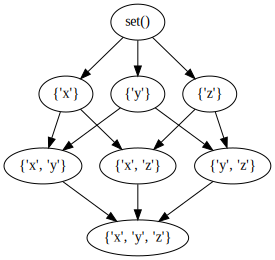

In [24]:
L.plot()

TODO: There's a problem here, in that our lattice is plotted upside down. If you know how to get GraphViz to plot this the other way round, do let me know.

Our first dataflow analysis using lattices will be reaching definitions, using our usual example code snippet.

In [25]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        int tmp = x;
        if(tmp % 2 == 0)
            y = x;
        x--;
    }

    return y;
  }
"""

In [26]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()

Each element of the CFG shall be assigned a set of definitions that reach this node. Thus, we need to retrieve all possible definitions, and then create a powerset lattice from that.

In [27]:
definitions = []
for node in cfg.nodes():
    definitions.extend([definition for definition in node.definitions()])

In [28]:
definitions

[Definition(name='x', node=<__main__.StartNode object at 0x10d3ec130>),
 Definition(name='y', node=<__main__.CFGNode object at 0x10d3ec0d0>),
 Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>),
 Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>),
 Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>)]

In [29]:
def powerset(A):
    length = len(A)
    return [
        set({e for e, b in zip(A, f'{i:{length}b}') if b == '1'})
        for i in range(2 ** length)
    ]

In [30]:
powerset(definitions)

[set(),
 {Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>)},
 {Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>)},
 {Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>),
  Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>)},
 {Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>)},
 {Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>),
  Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>)},
 {Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>),
  Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>)},
 {Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>),
  Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>),
  Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>)},
 {Definition(name='y', node=<__main__.CFGNode object at 0x10d3ec0d0>)},
 {Definition(name='x', node=<__main__.CFGNode object 

Reaching definitions is a forward may analysis, which means that the initial flow values will be empty sets. For our lattice, this means that bottom is the empty set, and top will be the set of all definitions. The lattice join operation will be set union.

In [31]:
U = list(powerset(definitions))
join = union
meet = intersection

L = Lattice(U, join, meet)

In [32]:
L.bottom

LatticeElement(L, set())

In [33]:
L.top

LatticeElement(L, {Definition(name='x', node=<__main__.CFGNode object at 0x10d3ecb50>), Definition(name='x', node=<__main__.StartNode object at 0x10d3ec130>), Definition(name='y', node=<__main__.CFGNode object at 0x10d3ecbb0>), Definition(name='tmp', node=<__main__.CFGNode object at 0x10d3eca60>), Definition(name='y', node=<__main__.CFGNode object at 0x10d3ec0d0>)})

The transfer function is the usual one, resulting in the union of the facts generated at a node with the difference of the in facts (result of joining the facts of the incoming edges) and the facts killed at the node. We only need to slightly rewrite this to use our lattice wrapper objects.

In [34]:
def reaching_definitions(node, in_facts):
    gen  = set(node.definitions())
    defined_vars = [definition.name for definition in gen]
    kill = set([definition for definition in in_facts.unwrap if definition.name in defined_vars])
    return in_facts.lattice.wrap(gen | (in_facts.unwrap - kill))

### Monotone framework

The monotone framework is, essentially, the lattice-centric interpretation of the iterative dataflow analysis framework we introduced in the previous chapter. We only need to slightly modify the actual algorithm. In particular, we initialise all facts using the bottom element of the lattice (= no information). Our worklist will consider individual edges, so rather than using an explicit flow direction we can just reverse the edges if we need to do a backward analysis.

In [35]:
class DataFlowAnalysis:
    def __init__(self, cfg, program_lattice, transfer_function, is_backward):
        self.cfg = cfg
        if is_backward:
            self.cfg = cfg.reverse()
            
        self.transfer_function = transfer_function
        self.lattice = program_lattice
        
        self.facts = {}
        
        for node in cfg.nodes():
            self.facts[node] = program_lattice.bottom

The analysis itself considers edges, and for each edge `(node1, node2)` checks if the outgoing facts calculated by applying the transfer function on what is known for `node1` is less than or equal to (according to the partial order) what is already known for `node2`. If not, we need to recalculate everything outgoing from `node2`.

In [36]:
class DataFlowAnalysis(DataFlowAnalysis):
    def apply(self):
            
        worklist = [(edge[0], edge[1]) for edge in self.cfg.edges()]
        while worklist:
            node1, node2 = worklist.pop()
            
            result = self.transfer_function(node1, self.facts[node1])
            self.facts[node1] = result
            if not (result <= self.facts[node2]):
                self.facts[node2] = self.lattice.join(self.facts[node2], result)
                for successor in self.cfg.successors(node2):
                    worklist.append((node2, successor))

In [37]:
analysis = DataFlowAnalysis(cfg, L, reaching_definitions, False)

In [38]:
analysis.apply()

In [39]:
for node, defs in analysis.facts.items():
    defstr = [str(x) for x in defs.unwrap]
    print(f"Node {node}: {defstr}")

Node Start: ['Def: x in line 2']
Node End: ['Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6', 'Def: y in line 3']
Node 3: ['Def: x in line 2', 'Def: y in line 3']
Node 5: ['Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6', 'Def: y in line 3']
Node 6: ['Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6', 'Def: y in line 3']
Node 7: ['Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6', 'Def: y in line 3']
Node 8: ['Def: tmp in line 6', 'Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8']
Node 9: ['Def: y in line 8', 'Def: tmp in line 6', 'Def: x in line 9', 'Def: y in line 3']
Node 12: ['Def: x in line 9', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6', 'Def: y in line 3']


For easier interpretation, here is the program we are analysing.

In [40]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


## Abstract Interpretation

So far we only considered powerset lattices representing sets of known facts per node, but the lattice-theoretic approach allows us to also use arbitrary abstractions for values in our program.

### Example abstract domain: Zero analysis

The running example will be a zero analysis: This analysis checks if a division-by-zero error may or will happen in a program. We define an enum that captures the two possible values, zero and nonzero.

In [41]:
from enum import Enum
class IntegerValue(Enum):
    ZERO = 1
    NONZERO = 2
    
    def __repr__(self):
        return self.name

The elements of our lattice will be emptyset for no information, zero or nonzero if we know what a value is, and the set {zero, nonzero} if it can be anything.

In [42]:
powerset = [set(), {IntegerValue.ZERO}, {IntegerValue.NONZERO}, {IntegerValue.ZERO, IntegerValue.NONZERO}]

In [43]:
join = union
meet = intersection

zero_lattice = Lattice(powerset, join, meet)

In [44]:
zero_lattice.bottom

LatticeElement(L, set())

In [45]:
zero_lattice.top

LatticeElement(L, {NONZERO, ZERO})

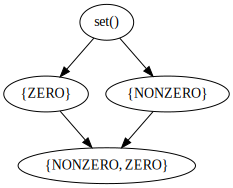

In [46]:
zero_lattice.plot()

As a shortcut, we'll define some variables to access the lattice elements.

In [47]:
zero = zero_lattice.wrap({ IntegerValue.ZERO })

In [48]:
nonzero =  zero_lattice.wrap({ IntegerValue.NONZERO })

In [49]:
maybezero = zero_lattice.wrap({ IntegerValue.ZERO, IntegerValue.NONZERO })

### From integers to the abstract domain

In order to apply abstract interpretation we require an abstraction function that maps concrete values to the abstract domain.

In [50]:
from functools import singledispatch

In [51]:
@singledispatch
def alpha(arg):
    raise NotImplementedError(f"Cannot abstract {arg}") 

In [52]:
@alpha.register(int)
def alpha_number(number):
    if number == 0:
        return zero
    else:
        return nonzero

In [53]:
alpha(0)

LatticeElement(L, {ZERO})

In [54]:
alpha(1)

LatticeElement(L, {NONZERO})

Similarly, we need to define abstractions of the operations we can perform on concrete values in the concrete domain.

In [55]:
def abstract_addition(op1, op2):
    if op1 == zero_lattice.bottom or op2 == zero_lattice.bottom:
        return zero_lattice.bottom
    elif op1 == zero:
        if  op2 == zero:
            return zero
        elif op2 == nonzero:
            return nonzero
    elif op2 == zero and op1 == nonzero:
            return nonzero
    else:
        return maybezero

In [56]:
abstract_addition(zero, zero)

LatticeElement(L, {ZERO})

In [57]:
abstract_addition(nonzero, zero)

LatticeElement(L, {NONZERO})

In [58]:
abstract_addition(nonzero, maybezero)

LatticeElement(L, {NONZERO, ZERO})

In [59]:
abstract_subtraction = abstract_addition

In [60]:
abstract_subtraction(nonzero, nonzero)

LatticeElement(L, {NONZERO, ZERO})

In [61]:
def abstract_multiplication(op1, op2):
    if op1 == zero or op2 == zero:
        return zero
    elif op1 == nonzero and op2 == nonzero:
        return nonzero
    elif op1 == maybezero and op2 == maybezero:
            return maybezero
    else:
        return zero_lattice.bottom

In [62]:
abstract_multiplication(maybezero, zero)

LatticeElement(L, {ZERO})

In [63]:
abstract_multiplication(alpha(0), alpha(10))

LatticeElement(L, {ZERO})

In [64]:
abstract_multiplication(alpha(10), alpha(10))

LatticeElement(L, {NONZERO})

In [65]:
def abstract_division(op1, op2):
    if op2 == zero:
        return zero_lattice.bottom
    elif op1 == zero_lattice.bottom:
        return zero_lattice.bottom
    elif op1 == zero:
        return zero
    elif op1 == nonzero and op2 == nonzero:
        return nonzero
    elif op1 == nonzero and op2 == maybezero:
        return nonzero
    elif op1 == zero_lattice.bottom:
        return zero_lattice.bottom
    else:
        return maybezero

In [66]:
abstract_division(alpha(0), alpha(10))

LatticeElement(L, {ZERO})

In [67]:
abstract_division(alpha(10), alpha(10))

LatticeElement(L, {NONZERO})

### Abstract transfer function

Finally, abstract interpretation requires us to define how to interpret program statements in our abstract domain. That is, we need to define a transfer function that updates abstract flow values based on the operations encoded in a program statement. The state of a program is represented by a map `values` of variable names to their abstract values. The transfer function thus takes the abstract values of the variables and the abstract operations, and updates `values`.

Let's consider an example function.

In [68]:
code2 = """
void foo() {
  int x = 8;
  int y = x;
  int z = 0;
  while (y > -1) {
    x = x / y;
    y = y - 2; 
    z = 5;
  }
}
"""

In [69]:
tree2 = parse_method(code2)
cfg2 = CFGBuilder(tree2).create_graph()

Now we need to generalise $\alpha$ to transform entire expressions.

In [70]:
@singledispatch
def alpha(arg, values):
    raise NotImplementedError(f"Cannot abstract {arg}") 

The easiest case is given by literal values (and we assume we only have programs with numeric values.

In [71]:
@alpha.register(int)
def alpha_number(number, values = {}):
    if number == 0:
        return zero
    else:
        return nonzero

In [72]:
@alpha.register(javalang.tree.Literal)
def alpha_literal(lit, values):
    return alpha(lit.value, values)

The dictionary `values` maps each variable to a lattice element. Thus, if the program accesses the value of a variable, we just need to look up the abstract value from `values.

In [73]:
@alpha.register(javalang.tree.MemberReference)
def alpha_member(member, values):
    if member.member in values:
        return values[member.member]
    else:
        return zero_lattice.BottomElement

We assume only numeric values, but for the sake of completeness, let's also interpret strings, as numbers.

In [74]:
@alpha.register(str)
def alpha_string(string, values):
    return alpha_number((int(string)), values)

Assigning a value evaluates the right hand side expression using $\alpha$, and updates `values` with the result for the left hand side variable.

In [75]:
@alpha.register(javalang.tree.Assignment)
def alpha_assignment(assignment, values):
    if not isinstance(assignment.expressionl, javalang.tree.MemberReference):
        raise NotImplementError(f"Assignment not implemented for {assignment.expressionl}")

    var = assignment.expressionl.member
    values[var] = alpha(assignment.value, values)

We will only handle a restricted set of operations, in particular binary operations on numbers. Depending on the operator, we just need to call the corresponding abstract operation, and pass in the abstract values.

In [76]:
@alpha.register(javalang.tree.BinaryOperation)
def alpha_operation(operation, values):
    lhs = alpha(operation.operandl, values)
    rhs = alpha(operation.operandr, values)
    op  = operation.operator
    if op == "+":
        return abstract_addition(lhs, rhs)
    elif op == "-":
        return abstract_subtraction(lhs, rhs)
    elif op == "*":
        return abstract_multiplication(lhs, rhs)
    elif op == "/":
        return abstract_division(lhs, rhs)
    else:
        raise NotImplementedError(f"Operator not implemented: {op}") 

Local variable declarations in javalang can have expressions on the right hand side with which to initialise the variable.

In [77]:
@alpha.register(javalang.tree.LocalVariableDeclaration)
def alpha_declaration(declaration, values):
    var = declaration.declarators[0].name
    value = alpha(declaration.declarators[0].initializer, values)
    values[var] = value

We need to recursively call the transfer function on the relevant AST classes.

In [78]:
@alpha.register(javalang.tree.StatementExpression)
def alpha_statement(statement, values):
    alpha(statement.expression, values)

While statements do not update values (we are ignoring prefix/postfix increment and decrement).

In [79]:
@alpha.register(javalang.tree.WhileStatement)
def alpha_while(whilestatement, values):
    pass

Neither do return statements.

In [80]:
@alpha.register(javalang.tree.ReturnStatement)
def alpha_return(statement, values):
    pass

...or if statements.

In [81]:
@alpha.register(javalang.tree.IfStatement)
def alpha_if(statement, values):
    pass

...and we also ignore the method declaration itself.

In [82]:
@alpha.register(javalang.tree.MethodDeclaration)
def alpha_method(statement, values):
    pass

For example, line 3 contains a declaration of variable `x`.

In [83]:
cfg2.node_for_line(3).ast_node

LocalVariableDeclaration(annotations=[], declarators=[VariableDeclarator(dimensions=[], initializer=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=8), name=x)], modifiers=set(), type=BasicType(dimensions=[], name=int))

In [84]:
values = {}

In [85]:
alpha(cfg2.node_for_line(3).ast_node, values)

In [86]:
values

{'x': LatticeElement(L, {NONZERO})}

Line 4 declares `y` and assigns it the value of `x`.

In [87]:
alpha(cfg2.node_for_line(4).ast_node, values)

In [88]:
values

{'x': LatticeElement(L, {NONZERO}), 'y': LatticeElement(L, {NONZERO})}

Line 5 assigns `0` to `z`.

In [89]:
alpha(cfg2.node_for_line(5).ast_node, values)

In [90]:
values

{'x': LatticeElement(L, {NONZERO}),
 'y': LatticeElement(L, {NONZERO}),
 'z': LatticeElement(L, {ZERO})}

Line 6 is a conditional statement and makes no assignment.

In [91]:
alpha(cfg2.node_for_line(6).ast_node, values)

In [92]:
values

{'x': LatticeElement(L, {NONZERO}),
 'y': LatticeElement(L, {NONZERO}),
 'z': LatticeElement(L, {ZERO})}

Line 7 assigns `x` the value of `x/y`.

In [93]:
alpha(cfg2.node_for_line(7).ast_node, values)

In [94]:
values

{'x': LatticeElement(L, {NONZERO}),
 'y': LatticeElement(L, {NONZERO}),
 'z': LatticeElement(L, {ZERO})}

Line 8 assigns `y` the value of `y - 2`.

In [95]:
alpha(cfg2.node_for_line(8).ast_node, values)

In [96]:
values

{'x': LatticeElement(L, {NONZERO}),
 'y': LatticeElement(L, {NONZERO, ZERO}),
 'z': LatticeElement(L, {ZERO})}

Line 9 assigns the constant `5` to `z`.

In [97]:
alpha(cfg2.node_for_line(9).ast_node, values)

In [98]:
values

{'x': LatticeElement(L, {NONZERO}),
 'y': LatticeElement(L, {NONZERO, ZERO}),
 'z': LatticeElement(L, {NONZERO})}

The transfer function consists of updating all variables with the result of $\alpha$. In our case this simply means applying our `alpha` function on the current statement.

Fx:=e(σ) = σ[x ← αZI(e)]

In [99]:
def alpha_trans(node, in_facts):
    result = in_facts.copy()
    alpha(node.ast_node, result.values)

    return result

To fit things into our monotone framework, we need to capture the lattice not just for one, but for all variables in a program. We thus create a program lattice, which is essentially a product lattice assigning an independent value lattice to each variable.

In [100]:
class ProgramLattice(object):
    def __init__(self, variables, lattice):
        self.variables = variables
        self.lattice   = lattice
        self.values    = {}
        for var in variables:
            self.values[var] = lattice.bottom

    @property
    def bottom(self):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        for var in self.variables:
            new_lattice.values[var] = self.lattice.bottom
        return new_lattice
    
    def join(self, other):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        for var in self.variables:
            new_lattice.values[var] = self.lattice.join(self.values[var], other.values[var])
        return new_lattice
    
    def copy(self):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        new_lattice.values = self.values.copy()
        return new_lattice
    
    
    def __le__(self, other):
        for var in self.variables:
            if not (self.values[var] <= other.values[var]):
                return False

        return True

To create this program lattice, we first need to determine what the variables in our program are.

In [101]:
def variables(cfg):
    variables = set()
    for node in cfg.nodes():
        for definition in node.definitions():
            variables.add(definition.name)
    for use in node.uses():
        variables.add(use.name)
    
    return variables

In [102]:
variables(cfg2)

{'x', 'y', 'z'}

Now we can create a program lattice, where each variable is defined by a zero lattice.

In [103]:
P = ProgramLattice(variables(cfg2), zero_lattice)

We need to update our dataflow analysis framework just slightly, to make sure it uses the correct join function (small interface change here in our program lattice, hopefully to be removed in a future revision).

In [104]:
class DataFlowAnalysis:
    def __init__(self, cfg, program_lattice, transfer_function, is_backward):
        self.cfg = cfg
        if is_backward:
            self.cfg = cfg.reverse()
            
        self.transfer_function = transfer_function
        self.lattice = program_lattice
        
        self.facts = {}
        
        for node in cfg.nodes():
            self.facts[node] = program_lattice.bottom    

In [105]:
class DataFlowAnalysis(DataFlowAnalysis):
    def apply(self):
            
        worklist = [(edge[0], edge[1]) for edge in self.cfg.edges()]
        while worklist:
            node1, node2 = worklist.pop()
            
            result = self.transfer_function(node1, self.facts[node1])
            self.facts[node1] = result
            if not (result <= self.facts[node2]):
                self.facts[node2] = self.facts[node2].join(result)
                for successor in self.cfg.successors(node2):
                    worklist.append((node2, successor))

Finally, let's apply the dataflow analysis.

In [106]:
analysis = DataFlowAnalysis(cfg2, P, alpha_trans, False)

In [107]:
analysis.apply()

For each node, we now know that possible values for each variable.

In [108]:
for node, lattice in analysis.facts.items():
    defstr = [f"{var} = {value}" for var, value in lattice.values.items()]
    print(f"Node {node}: {defstr}")

Node Start: ['x = set()', 'y = set()', 'z = set()']
Node End: ['x = {NONZERO}', 'y = {NONZERO, ZERO}', 'z = {NONZERO, ZERO}']
Node 3: ['x = {NONZERO}', 'y = set()', 'z = set()']
Node 4: ['x = {NONZERO}', 'y = {NONZERO}', 'z = set()']
Node 5: ['x = {NONZERO}', 'y = {NONZERO}', 'z = {ZERO}']
Node 6: ['x = {NONZERO}', 'y = {NONZERO, ZERO}', 'z = {NONZERO, ZERO}']
Node 7: ['x = {NONZERO}', 'y = {NONZERO, ZERO}', 'z = {NONZERO, ZERO}']
Node 8: ['x = {NONZERO}', 'y = {NONZERO, ZERO}', 'z = {NONZERO, ZERO}']
Node 9: ['x = {NONZERO}', 'y = {NONZERO, ZERO}', 'z = {NONZERO}']


To build an analysis out of this information, what we need to do is check our program for division statements, and then check the divisor. If the value is `ZERO` then we know there will be a division by zero error, if it is `{ZERO, NONZERO}` then there may be a division by zero error.

In [109]:
def get_children(root):
    children = None

    if isinstance(root, javalang.tree.Node):
        yield root
        children = root.children
    else:
        children = root

    for child in children:
        if isinstance(child, javalang.tree.Statement):
            continue
    
        if isinstance(child, (javalang.tree.Node, list, tuple)):
            for node in get_children(child):
                yield node

In [110]:
for i, line in enumerate(code2.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 : void foo() {
  3 :   int x = 8;
  4 :   int y = x;
  5 :   int z = 0;
  6 :   while (y > -1) {
  7 :     x = x / y;
  8 :     y = y - 2; 
  9 :     z = 5;
 10 :   }
 11 : }
 12 : 


In [111]:
for node in cfg2.nodes():
    for expression in node.expressions():
        for _, binop in expression.expression.filter(javalang.tree.BinaryOperation):
            if binop.operator == "/" and isinstance(binop.operandr, javalang.tree.MemberReference):
                if zero == analysis.facts[node].values[binop.operandr.member]:
                    print(f"Division by zero in line {node.ast_node.position.line - 1}")
                elif zero <= analysis.facts[node].values[binop.operandr.member]:
                    print(f"Potential division by zero in line {node.ast_node.position.line - 1}")


Potential division by zero in line 7


Let's also try an example where there's a guaranteed division by zero error.

In [112]:
code3 = """
void foo() {
  int x = 8;
  int y = 0;
  int z = x/y;
}
"""

In [113]:
tree3 = parse_method(code3)
cfg3 = CFGBuilder(tree3).create_graph()

In [114]:
P = ProgramLattice(variables(cfg3), zero_lattice)
analysis = DataFlowAnalysis(cfg3, P, alpha_trans, False)
analysis.apply()

In [115]:
for node in cfg3.nodes():
    for expression in node.expressions():
        for _, binop in expression.expression.filter(javalang.tree.BinaryOperation):
            if binop.operator == "/" and isinstance(binop.operandr, javalang.tree.MemberReference):
                if zero == analysis.facts[node].values[binop.operandr.member]:
                    print(f"Division by zero in line {node.ast_node.position.line - 1}")
                elif zero <= analysis.facts[node].values[binop.operandr.member]:
                    print(f"Potential division by zero in line {node.ast_node.position.line - 1}")

Division by zero in line 5
